In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers


import sys
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import matplotlib.pyplot as plt 
import random
import time 
import pandas as pd
import itertools

In [3]:
def parse_json(filepath, files):
    """
    function used to parse json of each commit json file

    Args:
        filepath_list - list of filepaths

    Returns:
        files_json - list object contains parsed information

    """

    files_json = []
    commit_ids = []
    # each commits
    #files = os.listdir(filepath)
    for path in files:
        commit_id = path.split("_")[1].split(".")[0]
        try:
            if os.stat(filepath + path).st_size != 0 and path != 'desktop.ini':
                with open(filepath + path, encoding="utf8") as f:
                    data = json.load(f)
                    files_list = []
                    # each file in commits
                    for file in data['files']:
                        # parse only cluster file
                        for key in file.keys():
                            if re.match('^.*_cluster$', key):
                                actions_list = []
                                actions = file[key]['actions']
                                # each action in file
                                for action in actions:
                                    actions_list.append(action['root'])
                                files_list.append(actions_list)
                if len(files_list) != 0:
                    files_json.append(files_list)
                    commit_ids.append(commit_id)
        except FileNotFoundError as e: 
            continue 
    assert(len(commit_ids) == len(files_json))      
    # return
    return files_json, commit_ids


folder_path = 'C:\\Users\\ichel\\Desktop\\tmp_JSON_labeled_commits\\'
all_files, csha = parse_json(folder_path)

In [4]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0].strip()
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()] + [
                        temp.split('INS ')[1].rsplit('to ')[-1].strip()
                    ]
                    for items in words:
                        items = items.split(':')[0].strip()
                        tempq.append(items)
                    if tempq[1] == 'TextElement' and tempq[-1] not in ['TagElement', 'TextElement']:
                        tempq[-1] = ''
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split('from ')[1].strip()
                    tempq.append('MOVE')
                    tempq.append(temp2.split(':')[0].strip())
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(':')[0].strip())
                    temp = '_'.join(tempq)
                temp = temp.replace(' ', '_')
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i
        i += 1
    return dic, files_data, counting

In [5]:
dic, datas, freq_dict = preprocess_roots(all_files)
rev_dic = dict(zip(dic.values(), dic.keys()))
print(len(dic))

442


In [6]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

In [7]:
def check_index_strange_words(training_data):
    for i, item in enumerate(training_data):
        for j, file in enumerate(item):
            for k, action in enumerate(file.split()):
                index = dic.get(action)
                if index is None: # for debug 
                    print("==============================")
                    print(action) # for debug 
                    print('commits index: %d'%i)
                    print('file: %d'%j)
                    print('action: %d'%k)
check_index_strange_words(training_data)

## Permute Order of File 
**Purpose**: Here we permutate the order of files within a given commit while still maintaining the labels for that commit. 
This helps our CNN by: 
- 1) Increasing the training samples 
- 2) Make the CNN invariant to file location 

In [8]:
# drop labels
def drop_labels(df, labels):
    """
    Drop some of labels

    Args:
    df - Dataframs
    labels - List of labels name to drop

    Returns:
    new_df -  new dataframe
    """
    # remove labels in categories list
    new_df = df.copy()
    new_df['categories'] = new_df['categories'].apply(lambda row: [item for item in row if item not in labels])

    # remove columns
    new_df = new_df.drop(labels, axis=1)

    # remove columns which have no labels after removing labels
    new_df['number_of_labels'] = new_df['categories'].apply(lambda row: len(row))
    new_df = new_df[new_df['number_of_labels'] != 0].reset_index(drop=True)
    new_df = new_df.drop(['number_of_labels'], axis=1)
    return new_df

In [9]:
# group some of labels
def group_labels(df, labels_to_group, new_label):
    '''
    Group some of labels

    Args:
        df - dataframe
        labels_to_group -  List of labels you want to group
        new_label -  string - new label name of grouped labels

    Returns:
        new_df - dataframe after grouped
    '''
    new_df = df.copy()

    # generate new labels by group labels
    def create_new_label(row, labels):
        new_label = 0  # initialize new label
        for label in labels:
            if row[label] == 1:
                new_label = 1  # if one of labels in grouped labels is 1 the new label is 1
        return new_label

    new_df[new_label] = df.apply(lambda row: create_new_label(row, labels_to_group), axis=1)

    # drop old labels
    new_df = new_df.drop(labels_to_group, axis=1)
    
    # generate list of new_categories

    return new_df

## Data Preperation: 
Prepare data for embedding and training .

In [10]:
def permutate_files(csha, training_data): 
    commits_dic = dict()
    for sha, training_file in zip(csha, training_data): 
        commits_dic[sha] = []
        if len(training_file) <= 6: 
            tmp_permutate = list(itertools.permutations(training_file))
            for permutated_file in tmp_permutate: 
                commits_dic[sha].append(list(permutated_file))
        else: 
            commits_dic[sha].append(training_file)
    return commits_dic 

In [13]:
def expand_list(commits_labels_df):
    s= commits_labels_df.apply(lambda x: pd.Series(x['Files']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = "Files"
    commits_labels_df = commits_labels_df.drop("Files", axis=1) 
    commits_labels_df = commits_labels_df.join(s)
    return commits_labels_df

In [23]:
commits_df = pd.DataFrame(data = [csha, training_data]).T
commits_df.columns = ["Commit ID", "Files"]
df_new = pd.read_csv('C:\\Users\\ichel\\Desktop\\commit_data_new.csv')
print(df_new.shape)

# convert string to list
from ast import literal_eval

df_new['categories'] = df_new['categories'].apply(lambda x: literal_eval(x))
print(type(df_new['categories'].values[0]))
print(df_new['categories'].values[0])
df_new = df_new.drop(['Unnamed: 0'], axis = 1)
commits_labels_df = pd.merge(commits_df, df_new, on='Commit ID')
commits_labels_df.head(1)
commits_labels_df = drop_labels(commits_labels_df, ["Testing", "Build", "Versioning", "Indentation", "Internationalization", "Merge", \
                                                   "Module Move", "Module Remove", "Source Control", "Rename", "Initialization", \
                                                   "Module Add", "Data"])
commits_labels_df = group_labels(commits_labels_df, ["Cross", "Debug"], "Cross_")
commits_labels_df = group_labels(commits_labels_df, ["Legal", "Documentation"], "Documentation_")
commits_labels_df.shape

msk = np.random.rand(len(commits_labels_df)) < 0.8
train_df = commits_labels_df[msk]
test_df = commits_labels_df[~msk]

permutate_train_dic = permutate_files(train_df['Commit ID'],train_df['Files'])
permutate_train_df = pd.DataFrame(data = permutate_train_dic.items(), columns=['Commit ID','Files'])
train_df = train_df.drop(["Files"], axis=1)
train_df['Files'] = permutate_train_df['Files'].values
expanded_train_df = expand_list(train_df)

print('exp_train_df shape:',expanded_train_df.shape)
print('train_df shape:',train_df.shape)
print('test_df shape:',test_df.shape)
commit_files = commits_labels_df["Files"].values
commits_labels_df.columns

# commits_test_dic = dict()
# for sha, training_file in zip(csha, training_data): 
#     commits_dic[sha] = []
#     commits_dic[sha].append(training_file)
    
# commits_df = pd.DataFrame(commits_dic.items())
# commits_df.columns = ["Commit ID", "Files"]

# df_new = pd.read_csv('C:\\Users\\ichel\\Desktop\\commit_data_new.csv')
# print(df_new.shape)

# # convert string to list
# from ast import literal_eval

# df_new['categories'] = df_new['categories'].apply(lambda x: literal_eval(x))
# print(type(df_new['categories'].values[0]))
# print(df_new['categories'].values[0])
# df_new = df_new.drop(['Unnamed: 0'], axis = 1)
# commits_labels_df = pd.merge(commits_df, df_new, on='Commit ID')
# commits_labels_df.head(1)
# s= commits_labels_df.apply(lambda x: pd.Series(x['Files']),axis=1).stack().reset_index(level=1, drop=True)
# s.name = "Files"
# commits_labels_df = commits_labels_df.drop("Files", axis=1) 
# commits_labels_df = commits_labels_df.join(s)
# commits_labels_df = drop_labels(commits_labels_df, ["Testing", "Build", "Versioning", "Indentation", "Internationalization", "Merge", \
#                                                    "Module Move", "Module Remove", "Source Control", "Rename", "Initialization", \
#                                                    "Module Add", "Data"])
# commits_labels_df = group_labels(commits_labels_df, ["Cross", "Debug"], "Cross_")
# commits_labels_df = group_labels(commits_labels_df, ["Legal", "Documentation"], "Documentation_")
# commits_labels_df.shape
# commit_files = commits_labels_df["Files"].values
# commits_labels_df.columns

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']
exp_train_df shape: (18381, 13)
train_df shape: (624, 13)
test_df shape: (153, 13)


Index(['Commit ID', 'Files', 'project name', 'commit_message', 'Maintenance',
       'Feature Add', 'Bug fix', 'Clean up', 'Refactoring', 'Token Replace',
       'categories', 'Cross_', 'Documentation_'],
      dtype='object')

In [25]:
def concat_files_to_sentence(expanded_train_list): 
    concat_data = ""
    tmp_list = []
    for items in expanded_train_list:
        concat_data = " ".join(items)
        tmp_list.append(concat_data)
    return tmp_list
concat_train_data = concat_files_to_sentence(expanded_train_df["Files"])
concat_test_data = concat_files_to_sentence(test_df["Files"])
print(concat_train_data[0])
print("  ")
print(concat_test_data[0])

INS_NullLiteral_VariableDeclarationFragment INS_IfStatement_Block INS_Block_IfStatement MOVE_Block MOVE_IfStatement INS_VariableDeclarationStatement_Block INS_VariableDeclarationStatement_Block INS_IfStatement_Block MOVE_VariableDeclarationFragment MOVE_VariableDeclarationFragment MOVE_VariableDeclarationFragment INS_SimpleName_MethodInvocation INS_SimpleName_MethodInvocation INS_SimpleName_MethodInvocation MOVE_ClassInstanceCreation DEL_ClassInstanceCreation
  
UPDATE UPDATE


## Determine File Threshold 

<sample training data>:  ['UPDATE UPDATE']


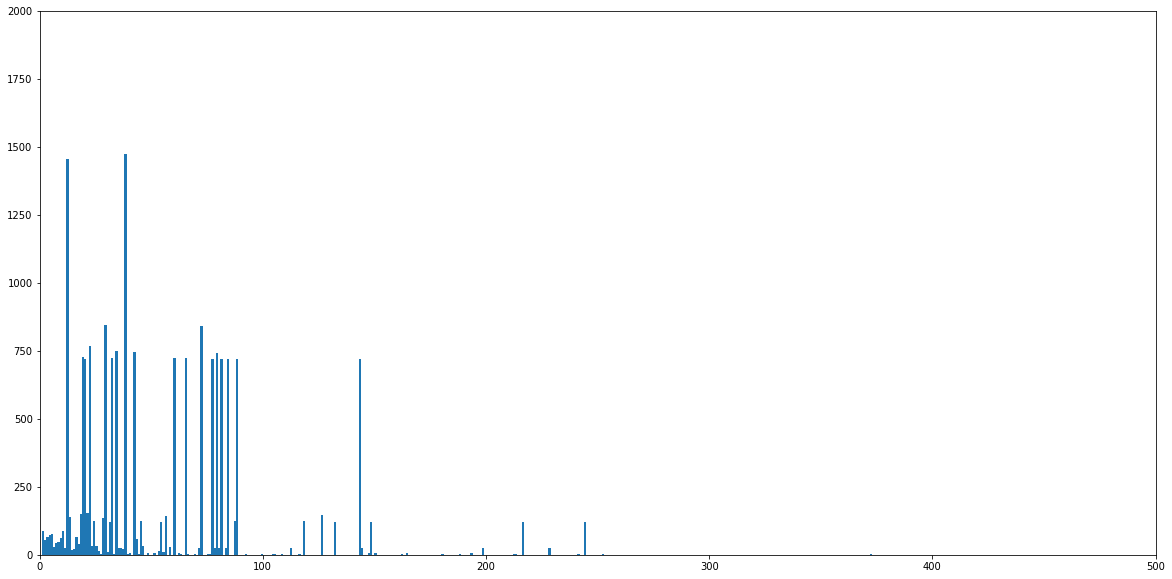

In [26]:
def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for item in training_data:
        seqlength_list.append(len(item.split()))
        if len(item.split()) >  max_root_len: 
            max_root_len = len(item.split())
    return max_root_len, seqlength_list

def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)
    plt.xlim((0, 500))
    plt.ylim((0, 2000))

max_seqlength, sequence_list = get_seqlength(concat_train_data)
print("<sample training data>: ", training_data[0])
plot_hist(sequence_list)

In [27]:
# getting file threshold
threshold = 0.95
number_of_actions = [len(item.split()) for item in concat_train_data]

def get_file_threshold(number_of_files, threshold = 0.95):
    '''
    get padding threshold for files dimension
    
    Args:
        number_of_files - array of the number of files in each commits
        threshold - drop all commits with its the number of files beyond this threshold
    Returns:
        padding threshold - number
    '''
    
    total_files = len(number_of_files)
    number_of_files = np.array(number_of_files)
    bincount = np.bincount(number_of_files)

    sum_file = 0
    for index, item in enumerate(bincount):
        sum_file += item
        #print(index,item)
        #print(sum_file)
        if sum_file > threshold*total_files:
            padding_files_threshold = index
            break
            
    return padding_files_threshold

length_threshold = get_file_threshold(number_of_actions, threshold)
print(length_threshold)

143


## Prepare Labels

In [31]:
expanded_train_df = expanded_train_df.drop(["Files"], axis=1)
test_df = test_df.drop(["Files"], axis=1)
expanded_train_df["Files"] = concat_train_data 
test_df["Files"] = concat_test_data 

In [33]:
expanded_train_df['len_seq'] = expanded_train_df.apply(lambda row: len(row['Files'].split()), axis = 1)
test_df['len_seq'] = test_df.apply(lambda row: len(row['Files'].split()), axis = 1)
expanded_train_df = expanded_train_df[expanded_train_df['len_seq'] <= length_threshold].reset_index(drop = True)
test_df = test_df[test_df['len_seq'] <= length_threshold].reset_index(drop = True)
print(test_df.columns)

Index(['Commit ID', 'project name', 'commit_message', 'Maintenance',
       'Feature Add', 'Bug fix', 'Clean up', 'Refactoring', 'Token Replace',
       'categories', 'Cross_', 'Documentation_', 'Files', 'len_seq'],
      dtype='object')


In [57]:
target_col = ["Maintenance", "Feature Add", "Bug fix", "Clean up", "Refactoring", "Token Replace", "Cross_", "Documentation_"]
y_train = expanded_train_df["Maintenance"].values
y_test = test_df["Maintenance"].values
print("traing labels shape: ", y_train.shape) 
print("test labels shape: ", y_test.shape)

traing labels shape:  (17869,)
test labels shape:  (132,)


## Tokenize and Pad data 
We tokenize the data and pad with the token <PAD/>.<br/> 

In [58]:
#Training 
train_docs = expanded_train_df['Files'].values
t_train = Tokenizer(filters = '', lower=False)
t_train.fit_on_texts(train_docs)

#Testing 
test_docs = test_df['Files'].values 
t_test = Tokenizer(filters = '', lower=False)
t_test.fit_on_texts(test_docs)

sequences_train = t_train.texts_to_sequences(train_docs)
sequences_test = t_test.texts_to_sequences(test_docs)
print(sequences_train[0])
print(sequences_test[0])

#Pad training data 
padded_seq_train = pad_sequences(sequences_train, maxlen=length_threshold + 1, padding="post", truncating="post")
print(padded_seq_train.shape)

#Pad testing data 
padded_seq_test = pad_sequences(sequences_test, maxlen=length_threshold + 1, padding="post", truncating="post")
print(padded_seq_test.shape)

[191, 28, 61, 12, 24, 13, 13, 28, 35, 35, 35, 8, 8, 8, 22, 49]
[1, 1]
(17869, 144)
(132, 144)


## Creating Testing and Training Set 

In [59]:
vocabulary_train = t_train.word_index
vocabulary_test = t_test.word_index 


vocabulary_inv_train = dict((v, k) for k, v in vocabulary_train.items())
vocabulary_inv_test = dict((v, k) for k, v in vocabulary_test.items())
vocabulary_inv_train[0] = "<PAD/>"
vocabulary_inv_test[0] = "<PAD/>"

In [60]:
X_train = padded_seq_train 
X_test = padded_seq_test
print(X_train[10, :])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

[  2   2  11  11  56   2   2   2   2   2  11  11  14  29 137  29  29 137
  29   1  13  28   1 170   1  53 247   1  64   1 171   1   1 171 115 115
   4   4  12   4 126   1  27  26 216 216 201 201 216 129   3   9  97 130
  14  14 108   8   1  40 215 140   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
(17869, 144)
(132, 144)
(17869,)
(132,)


### Embedding

In [61]:
def load_embedding(filename):
    """
    load embedding as python dictionary {root<str>: embeddings<np_array>}
    :param filename: embedding.txt 
    :return: dictionary object mapping root to embeddings 
    """
    if not os.path.exists(filename): 
        print("please run 'Store Pre-Trained Embeddings Cell!'")
    else: 
        with open(filename, "r") as f: 
            lines = f.readlines()
            f.close()
            # create map of words to vectors 
            embedding = dict()
            for line in lines: 
                comp = line.split()
                # map of <str, numpy array> 
                embedding[comp[0]] = np.asarray(comp[1:], dtype='float32')
            return embedding 

In [62]:
pre_embed = load_embedding("embedding.txt")

In [63]:
X_train = np.stack([np.stack([pre_embed [vocabulary_inv_train[action]] for action in commit]) for commit in X_train])
X_test = np.stack([np.stack([pre_embed[vocabulary_inv_test[action]] for action in commit]) for commit in X_test])
print("x_train static shape:", X_train.shape)
print("x_test static shape:", X_test.shape)

x_train static shape: (17869, 144, 300)
x_test static shape: (132, 144, 300)


### CNN for text

In [64]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
import warnings
warnings.filterwarnings('ignore')

In [68]:
# Model type. See Kim Yoon's Convolutional Neural Networks for Sentence Classification, Section 3
model_type = "CNN-non-static"  # CNN-rand|CNN-non-static|CNN-static

# Model Hyperparameters
embedding_dim = 300
filter_sizes = (5, 10)
num_filters = 10
dropout_prob = (0.5, 0.5)
hidden_dims = 50

# Training parameters
batch_size = 8
num_epochs = 10 #50

sequence_length = length_threshold

In [69]:
# input
input_shape = (sequence_length + 1, embedding_dim)
model_input = Input(shape=input_shape)

z = model_input

# dropout layer
z = Dropout(dropout_prob[0])(z)

# Convolutional block
conv_blocks = []
for sz in filter_sizes: # Feature > Maintenance > Clean  up > Bug fix > 
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)

model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer= optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), 
              metrics=["accuracy"])

In [70]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(X_test, y_test), verbose=2)

Train on 17869 samples, validate on 132 samples
Epoch 1/10
 - 22s - loss: 0.2032 - acc: 0.9168 - val_loss: 1.2427 - val_acc: 0.4848
Epoch 2/10
 - 22s - loss: 0.0868 - acc: 0.9661 - val_loss: 1.4030 - val_acc: 0.5076
Epoch 3/10
 - 21s - loss: 0.0666 - acc: 0.9711 - val_loss: 1.3696 - val_acc: 0.5076
Epoch 4/10
 - 21s - loss: 0.0567 - acc: 0.9744 - val_loss: 1.4601 - val_acc: 0.4924
Epoch 5/10
 - 21s - loss: 0.0488 - acc: 0.9788 - val_loss: 1.5317 - val_acc: 0.5152
Epoch 6/10
 - 21s - loss: 0.0455 - acc: 0.9815 - val_loss: 1.6529 - val_acc: 0.4924
Epoch 7/10
 - 21s - loss: 0.0446 - acc: 0.9813 - val_loss: 1.5653 - val_acc: 0.5000
Epoch 8/10
 - 21s - loss: 0.0414 - acc: 0.9820 - val_loss: 1.5183 - val_acc: 0.4924
Epoch 9/10
 - 21s - loss: 0.0379 - acc: 0.9838 - val_loss: 1.6483 - val_acc: 0.5076
Epoch 10/10
 - 21s - loss: 0.0367 - acc: 0.9835 - val_loss: 1.5959 - val_acc: 0.5000


In [71]:
y_pred = model.predict(X_test)

y_pred_bool = (y_pred > 0.5)

predictions = y_pred_bool.astype(int)

In [72]:
predictions

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
    

In [73]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))
    print('Hamming_loss:', hamming_loss(y_test, predicted))

In [74]:
print_evaluation_scores(y_test, predictions)

Accuracy: 0.5
F1-score macro: 0.49954044117647056
F1-score micro: 0.5
F1-score weighted: 0.5011488970588235
Hamming_loss: 0.5
